    r      Exact   Analytical   5% error     Linear
----- ---------- ------------ ---------- ----------
    2   0.729329    -0.000001   0.049920   0.000000
    4   0.945053    -0.000002   0.099840   0.000001
    6   0.990085    -0.000003   0.149759   0.000001
    8   0.998323    -0.000004   0.199679   0.000001
   10   0.999728    -0.000005   0.249598   0.000001
   12   0.999957    -0.000007   0.299518   0.000001
   14   0.999993    -0.000008   0.349437   0.000001
   16   0.999999    -0.000009   0.399357   0.000001
   18   1.000000    -0.000010   0.449276   0.000001
   20   1.000000    -0.000011   0.499196   0.000001
Interval (h): 0.10


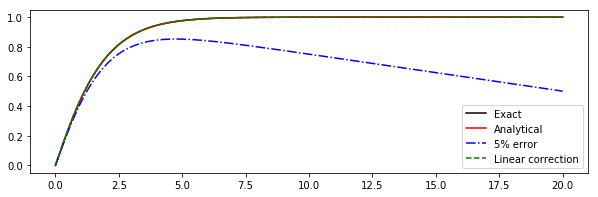

In [2]:
from __future__ import print_function
import numpy as np
#from scipy.constants import hbar
import matplotlib.pyplot as plt


def numerov(xgrid, y_0, y_1, k, S):
    """
    Numerov algorithm
   
    Solve 
   
        d^2
       ------y(x) + k(x)^2 * y(x) = S(x)
        dx^2
   
    by approximating the 2nd derivative 
    by the 3-point formula,
   
        yn+1 - 2yn + yn-1            h^2
       ------------------- = y''n + -----y''''n + O(h^4) .
               h^2                   12
   
    By some rearrangement,
   
             h^2                      5h^2               h^2
       (1 + -----kn+1^2)yn+1 - 2(1 - ------kn^2)yn + (1 + -----kn-1^2)yn-1
       
             12                        12                12
                    h^2
      = -----(Sn+1 + 10*Sn + Sn-1) + O(h^6)
         12
   
   
    *** One should know the the two initial points, k and S terms.
   
   
    - Case 1: Two initial values are given.
   
        y(0) = y0, y(1) = y1 --> y(2) is directly calculated.
   
   
    - Case 2: One initial value and its gradient is given.
   
        y(0) = y0, y'(0) = y'0 --> y(1) should be estimated by some formula.
   
        Then one can follow "Case 1".


    Inputs
    ------
    - xgrid : x (1-D array)
    
    - y_0   : y, initial condition 1
       Output
    ------
    - y : solution of the differential equation (1-D array)

    """
    # initialize y
    ngrid = len(xgrid)
    h = xgrid[1] - xgrid[0]
    y = np.zeros(ngrid)
    y[0] = y_0
    y[1] = y_1

    # main loop: evaluate y[j]
    for j in np.arange(2, ngrid):

        y1 = y[j-2]; y2 = y[j-1]
        k1 = k[j-2]; k2 = k[j-1]; k3 = k[j]
        s1 = S[j-2]; s2 = S[j-1]; s3 = S[j]

        term_S = 1/12. * h**2 * (s3 + 10*s2 + s1)
        term_3 =      (1 + 1/12. *   h**2 * k3**2)
        term_2 = -2 * (1 - 5/12. * 5*h**2 * k2**2) * y2
        term_1 =      (1 + 1/12. *   h**2 * k1**2) * y1

        y3 = (term_S - term_2 - term_1) / term_3
        y[j] = y3

    return y

#
# Poisson's equation when the charge distribution is
#
#                 1
#     rho(r) = ------ * exp(-r) .
#               8*pi 
#

def rho(xgrid):
    """
    Charge distribution function
    """
    return (1./(8.*np.pi))*np.exp(-xgrid)

def y_exact(xgrid):
    """
    Exact solution of Poisson's equation
    """
    return 1 - 0.5*(xgrid+2)*np.exp(-xgrid)

def linear(xgrid, x1, y1, x2, y2):
    """
    Determine the amount of linear correction
    """
    slope = (y2 - y1) / (x2 - x1)
    bias = y1 - slope * x1
    return slope * xgrid #+ bias

# domain 
xgrid = np.linspace(0., 20., 201)
ngrid = len(xgrid)

# initial values
y_0 = 0.; y_1 = y_exact(xgrid)[1]
k = np.zeros(ngrid)
S = np.zeros(ngrid); S += -4*np.pi * xgrid * rho(xgrid)

# Numerical solution with accurate initial points (Analytical)
y = numerov(xgrid, y_0, y_1, k, S)

# Numerical solution with inaccurate initial points (5% error)
y_err = numerov(xgrid, y_0, 0.95*y_1, k, S)

# Consider Linear correction (Linear)
y_cor = numerov(xgrid, y_0, 0.95*y_1, k, S)
x_1 = xgrid[-11]; x_2 = xgrid[-1]
y_1 = y_cor[-11]; y_2 = y_cor[-1]
y_cor -= linear(xgrid, x_1, y_1, x_2, y_2)


#
# Table3.1
#
print ("%5s %10s %12s %10s %10s" % \
      ('    r', '     Exact', '  Analytical', '  5% error', '    Linear'))
print ("%5s %10s %12s %10s %10s" % \
      ('-----', '----------', '------------', '----------', '----------'))

h = xgrid[1]-xgrid[0]
for j in range(20,201,20):
    x = int(j*h)
    y1 = y_exact(xgrid)[j]
    y2 = y1-y[j]
    y3 = y1-y_err[j]
    y4 = y1-y_cor[j]
    print ("%5i %10.6f %12.6f %10.6f %10.6f" % (x, y1, y2, y3, y4))
print ("Interval (h): %4.2f" % h)


#
# Figure
#
fig = plt.figure(figsize=(10,3))
fig1 = fig.add_subplot(111)
fig1.plot(xgrid, y_exact(xgrid), 'k-',  label='Exact')
fig1.plot(xgrid, y,              'r-',  label='Analytical')
fig1.plot(xgrid, y_err,          'b-.', label='5% error')
fig1.plot(xgrid, y_cor,          'g--', label='Linear correction')
fig1.legend()
plt.show()
